RAINSTORM

## Evaluate models
- This notebook will compare the performance of different trained models

#### Requirements:

- Models previously trained using RAINSTORM 3-Create_models.ipynb
- Access to the example file **colabels.csv**, where we can find:
    - Position and labels for representative exploration events
    - It includes the labels of 5 viewers (so far)

---
#### 1. Load the necessary modules

In [1]:
import os
import pandas as pd
import rainstorm.modeling as rst

rainstorm.create_models successfully imported. GPU devices detected: []


---
#### 2. State your project path & thresholds
`base` : The path to the downloaded repository. If you are using a Windows path with backslashes, place an ‘r’ in front of the directory path to avoid an error (e.g. r'C:\Users\dhers\Desktop\RAINSTORM').

`objects` : Name the stationary objects that appear on your data.

`bodyparts` : Name the bodyparts you want to use for training (to simplify the model, it is better to leave out the tail).

`labelers` : Names of the people that labeled the data (they should be the same as the columns in the `colabels` file).

`past` & `future` : If you use a LSTM model, you can set the window size by saying how many frames into the past and how many into the future you want to see.

`broad` : Once you have your window size, we can broaden the window by skipping some frames as we stray further from the present.

`use_model` : The name of the model you want to use for evaluation.

In [ ]:
# State your path:
base = r'C:\Users\dhers\Desktop\RAINSTORM'
models_folder = os.path.join(base, r'docs\models')
colabels = os.path.join(models_folder, 'colabels.csv')

objects = ['obj']
bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body']
labelers = ['Marian', 'Agus', 'Santi', 'Guille', 'Myself']

colabels_df = pd.read_csv(colabels)
position = colabels_df.filter(regex='_x|_y').filter(regex='^(?!.*tail)').copy() # Extract positions, excluding tail-related columns
manual_labels = pd.concat([colabels_df.filter(regex=name).copy() for name in labelers], axis=1) # Extract individual labelers' columns
geometric = colabels_df.filter(regex='Geometric').copy() # Extract geometric labels

past, future = 3, 3 # if you use a LSTM model, you can set the window size here
broad = 1.7 # using the same amount of frames, set how broad the window is (skipping frames)
broad_frames = rst.broaden(past, future, broad)
print(f'LSTM frame window: {broad_frames}')

use_model = 'example' # 'example' or a specific date, e.g. '2024-02-16'

LSTM frame window: [-6, -3, -1, 0, 1, 3, 6]


---
#### 3. Calculate a good reference labeler
Since we want to compare the models and the labelers, we need to create a reference labeler.

This reference could be the mean of all the labelers, but then the labelers would have an unfair advantage.

To avoid this, we choose to simultaneously create a chimera labeler and a leave-one-out-mean:
- The chimera is created by randomly selecting a labeler on each row of the data.
- The leave-one-out-mean is created by averaging the remaining labelers.

This way, we can compare the chimera to the leave-one-out-mean knowing that they are independent.

In [15]:
# Create the chimera and the leave-one-out mean
chimera, loo_mean = rst.create_chimera_and_loo_mean(manual_labels, seed=42) 
loo_mean = rst.smooth_columns(loo_mean, columns=['loo_mean'])

In [4]:
# We can still calculate the mean of all the labelers and see how it compares to the leave-one-out mean
full_mean = pd.DataFrame(manual_labels.sum(axis=1)/manual_labels.shape[1], columns=["full_mean"])

---
#### 4. Load the models & use them to label exploration on all the available data

In [5]:
# Load the saved models
from keras.models import load_model
model_simple = load_model(os.path.join(models_folder, f'm_simple/simple_{use_model}.keras'))
model_wide = load_model(os.path.join(models_folder, f'm_wide/wide_{use_model}_{len(broad_frames)}w.keras'))

from joblib import load
RF_model = load(os.path.join(models_folder, f'm_RF/RF_{use_model}.pkl'))

In [6]:
X_all = position.copy()

all_RF = rst.use_model(X_all, RF_model, objects=['obj'])
all_wide = rst.use_model(X_all, model_wide, objects=['obj'], reshaping = True, past=past, future=future, broad=broad)
all_simple = rst.use_model(X_all, model_simple, objects=['obj'])

c:\Users\dhers\miniconda3\envs\rainstorm\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


5220/5220 [==============================] - 4s 839us/step


In [16]:
# We can create a dictionary containing all labelers to compare them with the loo mean
all_labelers = {'simple': all_simple, 'wide': all_wide, 'RF': all_RF,
                'chimera': chimera, 'mean': loo_mean, 'geometric': geometric,} # , 'full_mean': full_mean

# add the manual labels to the dictionary
for name in labelers:
    all_labelers[name] = colabels_df.filter(regex=name).copy()

# Verify the updated dictionary
print(all_labelers.keys())  # Check the keys to confirm the additions

dict_keys(['simple', 'wide', 'RF', 'chimera', 'mean', 'geometric', 'Marian', 'Agus', 'Santi', 'Guille', 'Myself'])


---
#### 5. With all the labels organized, we can evaulate the performance of each

In [17]:
for name, pred in all_labelers.items():
    accuracy, precision, recall, f1, mse, mae, r2 = rst.evaluate(pred, loo_mean)
    print(f"Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, MSE = {mse:.4f}, MAE = {mae:.4f}, R-squared = {r2:.4f} -> {name}")

Accuracy = 0.9801, Precision = 0.9826, Recall = 0.9801, F1 Score = 0.9809, MSE = 0.0102, MAE = 0.0262, R-squared = 0.8072 -> simple
Accuracy = 0.9854, Precision = 0.9865, Recall = 0.9854, F1 Score = 0.9858, MSE = 0.0070, MAE = 0.0244, R-squared = 0.8671 -> wide
Accuracy = 0.9850, Precision = 0.9866, Recall = 0.9850, F1 Score = 0.9855, MSE = 0.0114, MAE = 0.0176, R-squared = 0.7838 -> RF
Accuracy = 0.9781, Precision = 0.9795, Recall = 0.9781, F1 Score = 0.9786, MSE = 0.0177, MAE = 0.0239, R-squared = 0.6645 -> chimera
Accuracy = 1.0000, Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000, MSE = 0.0000, MAE = 0.0000, R-squared = 1.0000 -> mean
Accuracy = 0.9746, Precision = 0.9732, Recall = 0.9746, F1 Score = 0.9726, MSE = 0.0231, MAE = 0.0293, R-squared = 0.5628 -> geometric
Accuracy = 0.9800, Precision = 0.9846, Recall = 0.9800, F1 Score = 0.9812, MSE = 0.0126, MAE = 0.0188, R-squared = 0.7613 -> Marian
Accuracy = 0.9801, Precision = 0.9802, Recall = 0.9801, F1 Score = 0.9783, MSE =

---
#### We can visualize the similarity between labelers using a cosine similarity plot

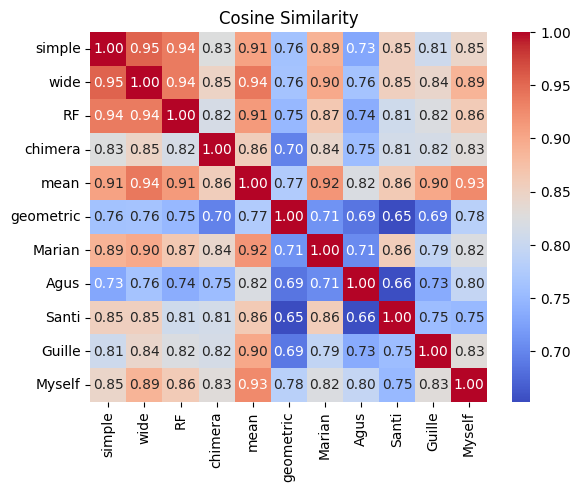

In [18]:
cosine_sim = rst.calculate_cosine_sim(all_labelers)

---
#### And finally, run a PCA (Principal Components Analysis) to see how much each labeler resembles eachother and the mean

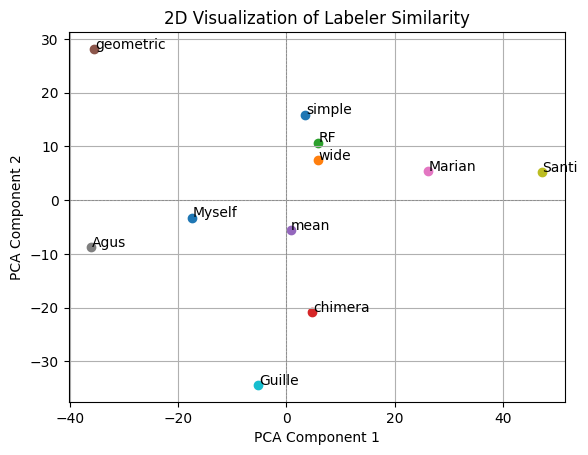

In [19]:
rst.plot_PCA(all_labelers)

---
#### Also, we can see both the models and the labelers performance on an example video

In [21]:
example_path = os.path.join(base, r'docs\examples\colabeled_video')

labelers_example = {
    "lblr_A": "Example_Marian.csv",
    "lblr_B": "Example_Agus.csv",
    "lblr_C": "Example_Santi.csv",
    "lblr_D": "Example_Guille.csv",
    "lblr_E": "Example_Myself.csv"
}

models = {
    "RF": (RF_model, {}),
    "Wide": (model_wide, {"reshaping": True}),
    "Simple": (model_simple, {}),
}

rst.plot_performance_on_video(example_path, models, labelers_example, plot_obj="obj_2")

c:\Users\dhers\miniconda3\envs\rainstorm\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



469/469 [==============================] - 0s 963us/step


---
---
#### Once we get to this point, we should have selected our favorite model.
We can move on to the next notebook and use the chosen model to label our files, 5-Automatic_analysis.ipynb

---
RAINSTORM - Created on Dec 12, 2023 - @author: Santiago D'hers